## Examples of how to use the optimization class

First lets import all the modules needed and generate a solver object

In [1]:
import numpy as np
import os
os.chdir('..')

from rss import rSNAPsim
from rss import ProbeVectorFactory as pvf  
from rss import PropensityFactory as pff
from rss import TranslationSolvers as tss
from rss import TranslationOptimization as topt
from rss import IntensityData as data_obj
from rss import IntensityAnalyses as int_a
os.chdir('./interactive_notebooks')

import matplotlib.pyplot as plt
import time


#Generate a solver object
rsim = rSNAPsim()
rsim.open_seq_file('../gene_files/Bactin_withTags.txt')  #open this sequence
poi = rsim.proteins['1'][0]  #protein object
solver = tss()  #solver class
solver.protein=poi #give the solver acess
t = np.linspace(0,500,501)


.\generalized_cpp
importing models


dict_keys(['ragged', 'head', 'ssa_obj', 'intensity_vec', 'times', 'I_mu', 'I_var'])


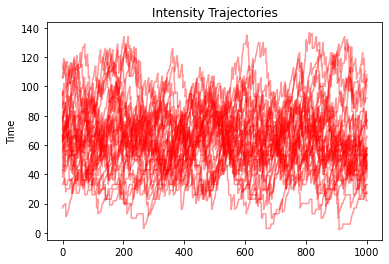

In [2]:
ki = [.08]
ke = [ 5]
colors = ['r']
i = 0
      
poi.ke_mu = ke[i] #half the speed
solver.default_conditions['burnin'] = 1000 #lets burnin for 1000s
solver.t = np.linspace(0,2000,2001)
solver.n_traj = 30
      
t = np.linspace(0,2000,2001)
ssa_soln = solver.solve_ssa([ki[i]] + poi.kelong + [10],t,n_traj=30)  
      
plt.plot(ssa_soln.intensity_vec[0],color=colors[i],alpha=.4)
plt.title('Intensity Trajectories')
plt.ylabel('Time')      
      
sim_data = data_obj()
sim_data.add_data(ssa_soln.time,ssa_soln.intensity_vec)
sim_data.get_stats()

print(sim_data.__dict__.keys())

### Lets generate a simulated data object with a specific parameter set

Text(0, 0.5, 'Time')

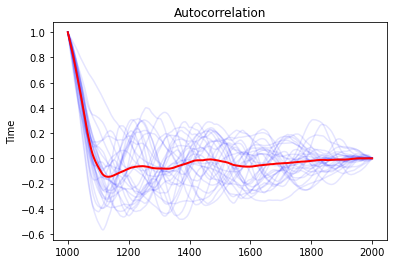

In [3]:
      
sim_acov, sim_acov_err = int_a().get_autocov(sim_data.intensity_vec,norm='ind')
sim_acc, sim_acc_err = int_a().get_autocorr(sim_acov)
sim_data.acorr = sim_acc
sim_data.acorr_err = sim_acc_err
sim_data.histogram = np.histogram(sim_data.intensity_vec,bins=30)[0]
sim_data.histogram_bins = np.histogram(sim_data.intensity_vec,bins=30)[1]



plt.figure()
plt.plot(sim_data.times,sim_data.acorr[0], alpha=.1,color='b')
plt.plot(sim_data.times,np.mean(sim_data.acorr[0],axis=1),color='r',lw=2)

plt.title('Autocorrelation')
plt.ylabel('Time')



In [4]:
opt = topt()  #Optimization object
opt.solver_obj = solver
opt.data_obj = sim_data
opt.parnames = ['ki','ke']
true_par = [.08,5]
opt.opts['bounds'] = ([0.01,.17],[0.1,12])

opt.initial_params = np.array([.033,10])
opt.params = np.array([.033,10])


In [6]:
opt.args['LL_acorr'] = (200,'ind','G0')
opt.args['LL_I_distb'] = (1,)
opt.run_optimization('LL_I_distb','MH',stepsize=[1,1],disp=True,mut_rate=.99,logspace=True,niter=500)


Burning in....


C:\Users\willi\Documents\GitHub\rSNAPsim\rss.py:3194: RuntimeWarning: divide by zero encountered in log
  LL = -np.dot(self.data_obj.histogram,np.log(dist_sim_data))
C:\Users\willi\Anaconda2\envs\newpy36clone\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


current iteration: 50 out of 500 | best_parameters: [-1.0969100130080565, 0.6989700043360189] | best evaulation: 136272.568818
current iteration: 100 out of 500 | best_parameters: [-1.0969100130080565, 0.6989700043360189] | best evaulation: 136272.568818
current iteration: 150 out of 500 | best_parameters: [-1.0969100130080565, 0.6989700043360189] | best evaulation: 136272.568818
current iteration: 200 out of 500 | best_parameters: [-1.0969100130080565, 0.6989700043360189] | best evaulation: 136272.568818
current iteration: 250 out of 500 | best_parameters: [-0.9222543352532737, 0.8549656238806088] | best evaulation: 136168.949456
current iteration: 300 out of 500 | best_parameters: [-0.9222543352532737, 0.8549656238806088] | best evaulation: 136168.949456
current iteration: 350 out of 500 | best_parameters: [-0.9222543352532737, 0.8549656238806088] | best evaulation: 136168.949456
current iteration: 400 out of 500 | best_parameters: [-0.9222543352532737, 0.8549656238806088] | best eva

-142781.71946238528

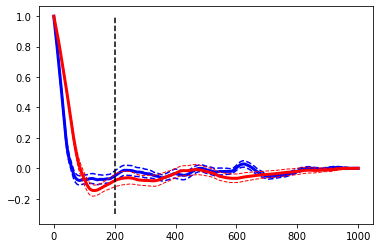

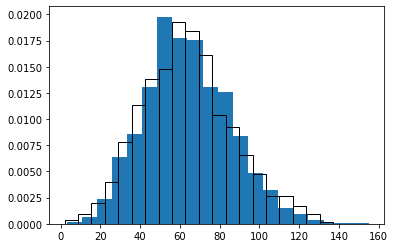

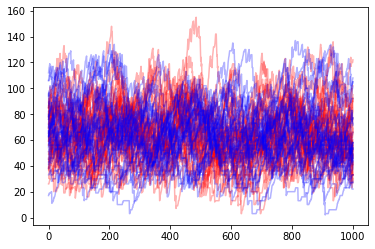

In [8]:

chain = opt.chain
intensity = opt.intensity_fun(chain.bestpar)
fit_acorr,fit_acorr_error = opt.autocorrelation_fun(intensity)
fit_acorr = np.mean(fit_acorr[0],axis=1)

plt.plot(fit_acorr,'b',lw=3)
plt.plot(fit_acorr-fit_acorr_error[0],'b--')
plt.plot(fit_acorr+fit_acorr_error[0],'b--')


plt.plot(np.mean(opt.data_obj.acorr[0],axis=1),'r',lw=3)
plt.plot(np.mean(opt.data_obj.acorr[0],axis=1) -opt.data_obj.acorr_err[0] ,'r--',lw=1)
plt.plot(np.mean(opt.data_obj.acorr[0],axis=1) +opt.data_obj.acorr_err[0] ,'r--',lw=1)

plt.plot([200,200],[-.3,1],'k--')


plt.figure()
int_hist = opt.intensity_distribution(intensity,bins = sim_data.histogram_bins)
counts1, bins = np.histogram(intensity,density=True,bins=20)
plt.hist(bins[:-1], bins, weights=counts1)

counts2, bins = np.histogram(sim_data.intensity_vec,density=True,bins=20)
counts3, bins3 = np.histogram(sim_data.intensity_vec,bins=20)
plt.hist(bins3[:-1], bins3, weights=counts2,fill=False)

plt.figure()
plt.plot(intensity[0],'r',alpha=.3)
plt.plot(sim_data.intensity_vec[0],'b',alpha=.3)


np.dot(counts3,np.log(counts1))
#np.sum(np.log(counts3*counts1))


In [ ]:
print(counts3)
print(counts1)

ValueError: cannot convert float NaN to integer

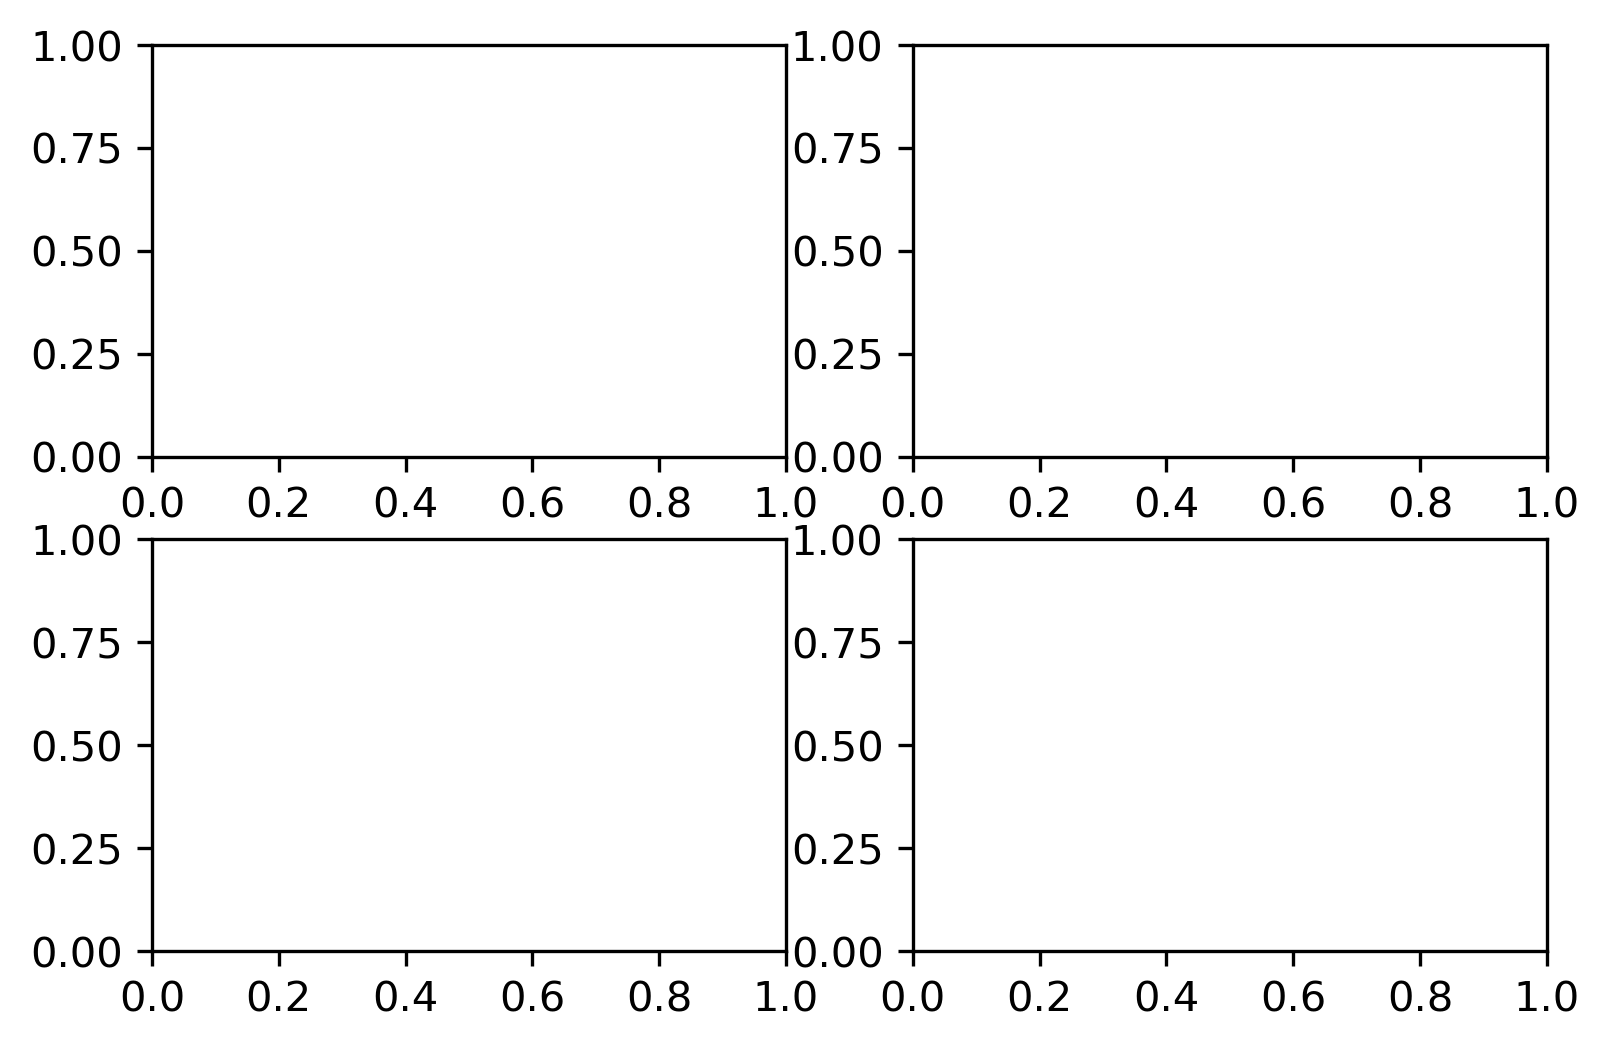

In [9]:
chain.parplot()

In [ ]:
plt.scatter(chain.parchain[:,0],chain.parchain[:,1])
plt.scatter([0.08],[5],color='red',s=150,marker='x')

plt.figure()
plt.plot(chain.evalchain)




In [ ]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('viridis', 2000)

colors = chain.evalchain
colors[colors>2000] = 2000
viridis(colors)

fig,ax = plt.subplots(1,1)
a = ax.scatter(chain.parchain[1:,0],chain.parchain[1:,1], c = colors)
ax.scatter([0.08],[5],color='red',s=150,marker='x',vmin=0, vmax=2000)


fig.colorbar(a, ax=ax)
ax.set_xlabel('Ki')
ax.set_ylabel('Ke')

In [10]:

opt.args['LL_acorr'] = (200,'ind','G0')
opt.args['LL_I_distb'] = (1,)
opt.run_optimization(['LL_acorr','LL_I_distb'],'MH',stepsize=[1,1],disp=True,mut_rate=.99,logspace=True,niter=500)

C:\Users\willi\Documents\GitHub\rSNAPsim\rss.py:3194: RuntimeWarning: divide by zero encountered in log
  LL = -np.dot(self.data_obj.histogram,np.log(dist_sim_data))


Burning in....


C:\Users\willi\Documents\GitHub\rSNAPsim\rss.py:3013: RuntimeWarning: invalid value encountered in double_scalars
  if f_new<f_old or np.random.rand()<np.exp(f_old-f_new):
C:\Users\willi\Anaconda2\envs\newpy36clone\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


current iteration: 50 out of 500 | best_parameters: [-1.1966766067934005, 0.6198536047205268] | best evaulation: 137048.281306
current iteration: 100 out of 500 | best_parameters: [-1.1966766067934005, 0.6198536047205268] | best evaulation: 137048.281306
current iteration: 150 out of 500 | best_parameters: [-1.0681321876615635, 0.7215763178532104] | best evaulation: 136375.894983
current iteration: 200 out of 500 | best_parameters: [-1.0681321876615635, 0.7215763178532104] | best evaulation: 136375.894983
current iteration: 250 out of 500 | best_parameters: [-1.0681321876615635, 0.7215763178532104] | best evaulation: 136375.894983
current iteration: 300 out of 500 | best_parameters: [-1.0681321876615635, 0.7215763178532104] | best evaulation: 136375.894983
current iteration: 350 out of 500 | best_parameters: [-1.0681321876615635, 0.7215763178532104] | best evaulation: 136375.894983
current iteration: 400 out of 500 | best_parameters: [-1.0681321876615635, 0.7215763178532104] | best eva

C:\Users\willi\Documents\GitHub\rSNAPsim\rss.py:3194: RuntimeWarning: divide by zero encountered in log
  LL = -np.dot(self.data_obj.histogram,np.log(dist_sim_data))


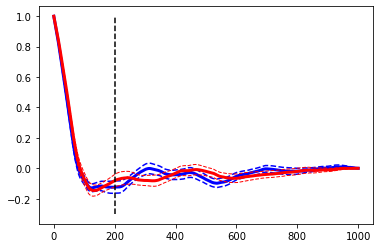

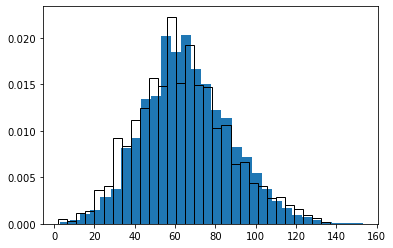

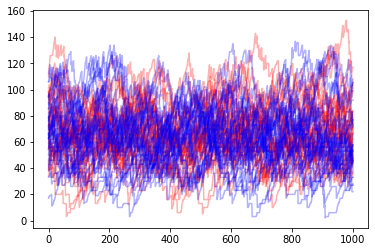

In [12]:
chain_2obj = opt.chain
intensity = opt.intensity_fun([.08,5])

LL = opt.combined_objective([.08,5],['LL_acorr','LL_I_distb'],opt.intensity_fun)

LL2 = opt.combined_objective(chain_2obj.bestpar,['LL_acorr','LL_I_distb'],opt.intensity_fun)


fit_acorr,fit_acorr_error = opt.autocorrelation_fun(intensity)
fit_acorr = np.mean(fit_acorr[0],axis=1)

plt.plot(fit_acorr,'b',lw=3)
plt.plot(fit_acorr-fit_acorr_error[0],'b--')
plt.plot(fit_acorr+fit_acorr_error[0],'b--')


plt.plot(np.mean(opt.data_obj.acorr[0],axis=1),'r',lw=3)
plt.plot(np.mean(opt.data_obj.acorr[0],axis=1) -opt.data_obj.acorr_err[0] ,'r--',lw=1)
plt.plot(np.mean(opt.data_obj.acorr[0],axis=1) +opt.data_obj.acorr_err[0] ,'r--',lw=1)

plt.plot([200,200],[-.3,1],'k--')

plt.figure()
int_hist = opt.intensity_distribution(intensity,bins = sim_data.histogram_bins)
counts1, bins = np.histogram(intensity,density=True,bins=30)
plt.hist(bins[:-1], bins, weights=counts1)

counts2, bins = np.histogram(sim_data.intensity_vec,density=True,bins=30)
plt.hist(bins[:-1], bins, weights=counts2,fill=False)

plt.figure()
plt.plot(intensity[0],'r',alpha=.3)
plt.plot(sim_data.intensity_vec[0],'b',alpha=.3)

In [ ]:
print(LL)
print(LL2)

C:\Users\willi\Anaconda2\envs\newpy36clone\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


Text(0, 0.5, 'Ke')

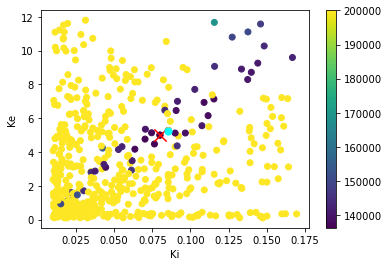

In [16]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('viridis', 200000)

colors = np.copy(chain_2obj.evalchain)

colors[colors>200000] = 200000
viridis(colors)

fig,ax = plt.subplots(1,1)
b = ax.scatter(chain_2obj.parchain[:,0],chain_2obj.parchain[:,1], c = colors)
a = ax.scatter([0.08],[5],color='red',s=150,marker='x',vmin=0, vmax=2000)
a = ax.scatter([chain_2obj.bestpar[0]],[chain_2obj.bestpar[1]],color='cyan',s=50,marker='o',vmin=0, vmax=2000)

fig.colorbar(b, ax=ax)
ax.set_xlabel('Ki')
ax.set_ylabel('Ke')

ValueError: cannot convert float NaN to integer

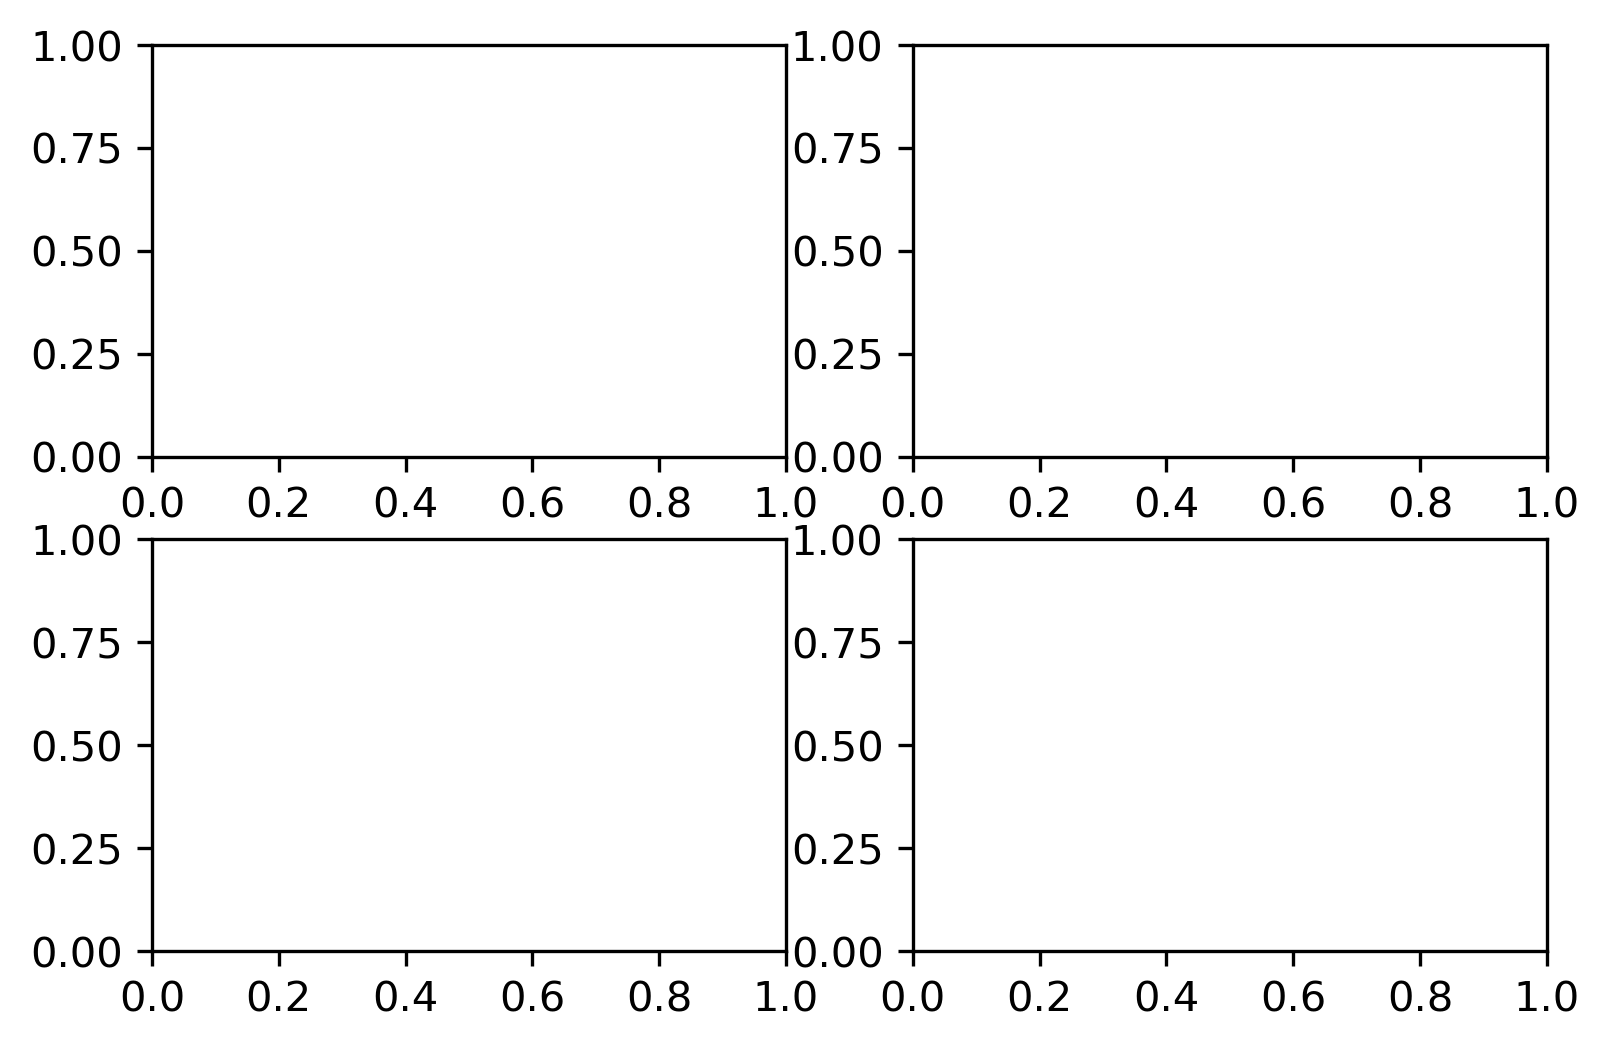

In [14]:
chain_2obj.parplot()

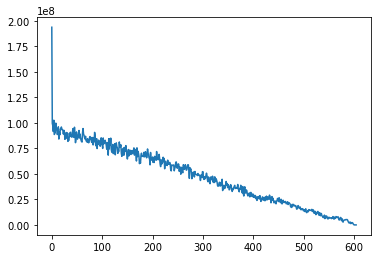

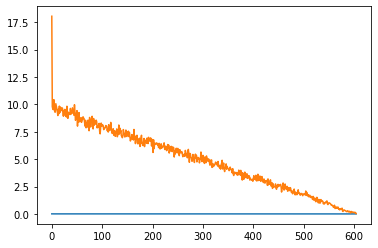

In [15]:
plt.figure()
chain_2obj.check_objfun_convergence()
plt.plot(chain_2obj.objfun_acc)

plt.figure()
chain_2obj.check_parameter_convergence()
plt.plot(chain_2obj.par_acc)